In [30]:
# Scenario Generation with Copulas 
# 
# Hugo S. de Araujo
# Nov. 14th, 2022 | Mays Group | Cornell University
################################################################################

#=======================================================================
PROJECT SETUP
=======================================================================#
using Pkg
Pkg.activate("copulas");
Pkg.instantiate();
# Import "here" function. Wrapper to allow easy path concatenation.
include(joinpath(@__DIR__, "functions", "fct_here.jl"))

# Import all required packages. 
begin
    # using AWSS3
    using CSV
    using DataFrames
    using Dates
    using DelimitedFiles
    using Distributions
    using HDF5
    using JuliaFormatter
    using LaTeXStrings
    using LinearAlgebra
    using LinearSolve
    #using Measures
    using Random
    using RCall
    using Revise
    using Statistics
    using StatsBase
    #using StatsPlots
    using OhMyREPL
    using Plots
    #using PrettyTables
    using Tables
    using TSFrames
    using TimeZones
end

# Include functions 
#= functions_dirpath = joinpath(pwd(),"src", "functions");
function_paths = readdir(functions_dirpath, join=true);
function_index = occursin.(".jl", function_paths);
functions_only = function_paths[function_index];

for str in functions_only
    include(str)
end =#

include(here("src", "functions", "fct_bind_historical_forecast.jl"));
include(here("src", "functions", "fct_compute_hourly_average_actuals.jl"));
include(here("src", "functions", "fct_compute_landing_probability.jl"));
include(here("src", "functions", "fct_convert_hours_2018.jl"));
include(here("src", "functions", "fct_convert_ISO_standard.jl"));
include(here("src", "functions", "fct_convert_land_prob_to_data.jl"));
include(here("src", "functions", "fct_generate_probability_scenarios.jl"));
include(here("src", "functions", "fct_getplots.jl"));
include(here("src", "functions", "fct_plot_correlation_heatmap.jl"));
include(here("src", "functions", "fct_plot_historical_landing.jl"));
include(here("src", "functions", "fct_plot_historical_synthetic_autocorrelation.jl"));
include(here("src", "functions", "fct_plot_correlogram_landing_probability.jl"));
include(here("src", "functions", "fct_plot_scenarios_and_actual.jl"));
include(here("src", "functions", "fct_read_h5_file.jl"));
include(here("src", "functions", "fct_read_input_file.jl"));
include(here("src", "functions", "fct_transform_landing_probability.jl"));
include(here("src", "functions", "fct_write_percentiles.jl"));
#=======================================================================
READ INPUT FILE
=======================================================================#
input_file_path = here("src\\copulas.txt")

# XXX Needs to be updated to be a hardcoded instead of reading in a text file
data_type,
scenario_length,
number_of_scenarios,
scenario_hour,
scenario_day,
scenario_month,
scenario_year,
read_locally,
historical_load,
forecast_load,
historical_solar,
forecast_da_solar,
forecast_2da_solar,
historical_wind,
forecastd_da_wind,
forecast_2da_wind,
write_percentile = read_input_file(input_file_path);

#=======================================================================
READ INPUT DATA: ARPA-E PERFORM PROJECT H5 FILES
=======================================================================#
# Function that reads the .h5 file and binds the time index and the actuals/fore-
# cast values into a single dataframe.

# Load data
load_actuals = read_h5_file(here("data", historical_load), "load");
load_forecast = read_h5_file(here("data", "ercot_BA_load_forecast_day_ahead_2018.h5"), "load", false);

# Solar data
solar_actuals = read_h5_file(here("data", "ercot_BA_solar_actuals_Existing_2018.h5"), "solar");
solar_forecast_dayahead = read_h5_file(here("data", "ercot_BA_solar_forecast_day_ahead_existing_2018.h5"), "solar", false);
solar_forecast_2dayahead = read_h5_file(here("data", "ercot_BA_solar_forecast_2_day_ahead_existing_2018.h5"), "solar", false);

# Wind data
wind_actuals = read_h5_file(here("data", "ercot_BA_wind_actuals_Existing_2018.h5"), "wind");
wind_forecast_dayahead = read_h5_file(here("data", "ercot_BA_wind_forecast_day_ahead_existing_2018.h5"), "wind", false);
wind_forecast_2dayahead = read_h5_file(here("data", "ercot_BA_wind_forecast_2_day_ahead_existing_2018.h5"), "wind", false);

#=======================================================================
Compute the hourly average for the actuals data
=======================================================================#
# Load
aux = compute_hourly_average_actuals(load_actuals);
load_actual_avg = DataFrame();
time_index = aux[:, :Index];
avg_actual = aux[:, :values_mean];
load_actual_avg[!, :time_index] = time_index;
load_actual_avg[!, :avg_actual] = avg_actual;

# Solar
aux = compute_hourly_average_actuals(solar_actuals);
time_index = aux[:, :Index];
avg_actual = aux[:, :values_mean];
solar_actual_avg = DataFrame();
solar_actual_avg[!, :time_index] = time_index;
solar_actual_avg[!, :avg_actual] = avg_actual;

# Wind
aux = compute_hourly_average_actuals(wind_actuals);
time_index = aux[:, :Index];
avg_actual = aux[:, :values_mean];
wind_actual_avg = DataFrame();
wind_actual_avg[!, :time_index] = time_index;
wind_actual_avg[!, :avg_actual] = avg_actual;



  Activating project at `c:\Users\ks885\Documents\aa_research\Modeling\norta_scenarios\copulas\src\copulas`

In [ ]:
#=======================================================================
ADJUST THE TIME 
=======================================================================#
#= For the year of 2018, adjust the time to Texas' UTC (UTC-6 or UTC-5)
depending on daylight saving time =#

# Load data
load_actuals = convert_hours_2018(load_actuals);
load_actual_avg = convert_hours_2018(load_actual_avg);
load_forecast = convert_hours_2018(load_forecast, false);
ahead_factor = repeat(["two", "one"], size(load_forecast, 1) ÷ 2)
load_forecast[!, :ahead_factor] = ahead_factor
load_forecast_dayahead = filter(:ahead_factor => ==("one"), load_forecast)
load_forecast_2dayahead = filter(:ahead_factor => ==("two"), load_forecast);

# Solar data
solar_actuals = convert_hours_2018(solar_actuals);
solar_actual_avg = convert_hours_2018(solar_actual_avg);
solar_forecast_dayahead = convert_hours_2018(solar_forecast_dayahead, false);
solar_forecast_2dayahead = convert_hours_2018(solar_forecast_2dayahead, false);

# Wind data
wind_actuals = convert_hours_2018(wind_actuals);
wind_actual_avg = convert_hours_2018(wind_actual_avg);
wind_forecast_dayahead = convert_hours_2018(wind_forecast_dayahead, false);
wind_forecast_2dayahead = convert_hours_2018(wind_forecast_2dayahead, false);

In [20]:
forecast_da_data = load_forecast
ahead_factor = repeat(["two", "one"], size(forecast_da_data, 1) ÷ 2)
forecast_da_data[!, :ahead_factor] = ahead_factor
load_da_data = filter(:ahead_factor => ==("one"), forecast_da_data)
load_2da_data = filter(:ahead_factor => ==("two"), forecast_da_data);

Now do load 1day ahead and wind solar 1day ahead forecasts equal each other?

In [26]:
println(load_da_data[:,:forecast_time] == wind_forecast_dayahead[:,:forecast_time])
println(load_da_data[:,:forecast_time] == solar_forecast_dayahead[:,:forecast_time])
println(wind_forecast_dayahead[:,:forecast_time] == solar_forecast_dayahead[:,:forecast_time])

true
true
true


Good, this means they are consistent even if there is an issue with the daylight savings time

Can the same be said about issue time?

In [27]:
println(load_da_data[:,:issue_time] == wind_forecast_dayahead[:,:issue_time])
println(load_da_data[:,:issue_time] == solar_forecast_dayahead[:,:issue_time])
println(wind_forecast_dayahead[:,:issue_time] == solar_forecast_dayahead[:,:issue_time])

true
true
true


Good. what now?

In [28]:
println(load_da_data[:,[:forecast_time, :issue_time]] == wind_forecast_dayahead[:,[:forecast_time, :issue_time]])
println(load_da_data[:,[:forecast_time, :issue_time]] == solar_forecast_dayahead[:,[:forecast_time, :issue_time]])
println(wind_forecast_dayahead[:,[:forecast_time, :issue_time]] == solar_forecast_dayahead[:,[:forecast_time, :issue_time]])

true


true
true


Have to check load_ two day ahead data as well...

In [29]:
println(load_2da_data[:,:forecast_time] == wind_forecast_2dayahead[:,:forecast_time])
println(load_2da_data[:,:forecast_time] == solar_forecast_2dayahead[:,:forecast_time])
println(wind_forecast_2dayahead[:,:forecast_time] == solar_forecast_2dayahead[:,:forecast_time])
println(load_2da_data[:,:issue_time] == wind_forecast_2dayahead[:,:issue_time])
println(load_2da_data[:,:issue_time] == solar_forecast_2dayahead[:,:issue_time])
println(wind_forecast_2dayahead[:,:issue_time] == solar_forecast_2dayahead[:,:issue_time])
println(load_2da_data[:,[:forecast_time, :issue_time]] == wind_forecast_2dayahead[:,[:forecast_time, :issue_time]])
println(load_2da_data[:,[:forecast_time, :issue_time]] == solar_forecast_2dayahead[:,[:forecast_time, :issue_time]])
println(wind_forecast_2dayahead[:,[:forecast_time, :issue_time]] == solar_forecast_2dayahead[:,[:forecast_time, :issue_time]])

true
true
true
true
true
true
true
true
true


In [12]:
#=======================================================================
BIND HOURLY HISTORICAL DATA WITH FORECAST DATA
========================================================================#
#= The binding is made by ("forecast_time" = "time_index"). This causes the 
average actual value to be duplicated, which is desired, given the # of rows
in the load_forecast is double that of load_actual. To distinguish a 
one-day-ahead forecast from a two-day-ahead forecast, the column "ahead_factor"
is introduced. Bind the day-ahead and two-day-ahead forecasts for wind and solar
to get all the forecast data into one object as it is for load forecast =#
    load_data = bind_historical_forecast(true,
    load_actual_avg,
    load_forecast);

solar_data = bind_historical_forecast(false,
    solar_actual_avg,
    solar_forecast_dayahead,
    solar_forecast_2dayahead);

wind_data = bind_historical_forecast(false,
    wind_actual_avg,
    wind_forecast_dayahead,
    wind_forecast_2dayahead);

In [15]:
wind_data[:,:forecast_time] == load_data[:,:forecast_time]

false

In [35]:
load_data = bind_historical_forecast(false,
load_actual_avg,
load_forecast_dayahead,
load_forecast_2dayahead);

In [34]:
println(wind_data[:,[:forecast_time, :issue_time]] == test_load_data[:,[:forecast_time, :issue_time]])
println(solar_data[:,[:forecast_time, :issue_time]] == test_load_data[:,[:forecast_time, :issue_time]])

true
true


In [37]:
wind_times = wind_data[!, [:forecast_time, :issue_time]]
unique_wind = unique(wind_data[!,:issue_time])

solar_times = solar_data[!, [:forecast_time, :issue_time]]
unique_solar = unique(solar_times[!,:issue_time])

load_times = load_data[!, [:forecast_time, :issue_time]]
unique_load = unique(load_times[!,:issue_time]);

In [38]:
# XXX load data needs to be fixed, for now just use wind_times
unique_wind == unique_load

true

In [47]:
# all times series for forecast and issue are equal so take any data and extract both
times = wind_data[!, [:forecast_time, :issue_time]]
unique_forecast = unique(times[!,:forecast_time])
unique_issue = unique(times[!, :issue_time]);

In [43]:
start_date = DateTime(string(scenario_year) * "-" * string(scenario_month) * "-" * string(scenario_day) * "T" * string(scenario_hour));

In [54]:
current_issue

2018-08-28T12:00:00

This begins the inside SLAC loop stuff

In [72]:
start_date > next_issue

true

Try figure out the T

In [73]:
length(unique_forecast)

8758

In [74]:
#=======================================================================
Landing probability
=======================================================================#
landing_probability_load = compute_landing_probability(load_data);
landing_probability_solar = compute_landing_probability(solar_data);
landing_probability_wind = compute_landing_probability(wind_data);

In [76]:
x = copy(landing_probability_load)
sort!(x, :issue_time);

# Group data by issue time and count occurences in every group
df = combine(groupby(x, [:issue_time]), DataFrames.nrow => :count);

# Filter data by count. Only keep groups with 48 entries
df_filtered = filter(:count => ==(48), df);

issue_times_interest = df_filtered[!, :issue_time];
landing_probability_filtered = innerjoin(x, df_filtered, on=:issue_time);
landing_probability_filtered_matrix = reshape(landing_probability_filtered[!, :landing_probability], (48, size(df_filtered, 1)));
landing_probability_filtered_matrix = transpose(landing_probability_filtered_matrix);

In [79]:
landing_probability_filtered

Row,issue_time,forecast_time,landing_probability,ahead_factor,count
,DateTime,DateTime,Float64,String,Int64
1,2017-12-31T12:00:00,2018-01-01T00:00:00,0.888889,one,48
2,2017-12-31T12:00:00,2018-01-01T01:00:00,0.585859,one,48
3,2017-12-31T12:00:00,2018-01-01T02:00:00,0.545455,one,48
4,2017-12-31T12:00:00,2018-01-01T03:00:00,0.505051,one,48
5,2017-12-31T12:00:00,2018-01-01T04:00:00,0.252525,one,48
6,2017-12-31T12:00:00,2018-01-01T05:00:00,0.505051,one,48
7,2017-12-31T12:00:00,2018-01-01T06:00:00,0.111111,one,48
8,2017-12-31T12:00:00,2018-01-01T07:00:00,0.444444,one,48
9,2017-12-31T12:00:00,2018-01-01T08:00:00,0.767677,one,48


In [80]:
x = copy(wind_data);
# Sort data by issue time
sort!(x, :issue_time);
# Group data by issue time and count occurences in every group
df = combine(groupby(x, [:issue_time]), DataFrames.nrow => :count);
# Filter data by count. Only keep groups with 48 entries
df_filtered = filter(:count => ==(48), df);
issue_times_interest = df_filtered[!, :issue_time];
# find all forecast times for these issue times of interest

359-element Vector{DateTime}:
 2017-12-31T12:00:00
 2018-01-01T12:00:00
 2018-01-02T12:00:00
 2018-01-03T12:00:00
 2018-01-04T12:00:00
 2018-01-05T12:00:00
 2018-01-06T12:00:00
 2018-01-07T12:00:00
 2018-01-08T12:00:00
 2018-01-09T12:00:00
 ⋮
 2018-12-20T12:00:00
 2018-12-21T12:00:00
 2018-12-22T12:00:00
 2018-12-23T12:00:00
 2018-12-24T12:00:00
 2018-12-25T12:00:00
 2018-12-26T12:00:00
 2018-12-27T12:00:00
 2018-12-28T12:00:00

In [132]:
subset_data = filter(row -> row[:issue_time] in issue_times_interest, wind_data);
subset_forecast_times = subset_data[!, :forecast_time];
unique_forecast_times = unique(subset_forecast_times);
forecast_T = length(unique_forecast_times)

unique_issue_times = unique(subset_wind_data[!, :issue_time]);

In [142]:
no_issues = length(unique_issue_times);
no_forecasts = length(unique_forecast_times);

no_forecasts/no_issues == 24
println(no_forecasts/no_issues)

24.200557103064067

* Why is it not exactly 24? 
    * is it because of daylight savings time?

In [146]:
(no_forecasts+4)/no_issues

24.211699164345404

        * no it does not appear to be the case

In [155]:
# Create an empty dataframe
test = DataFrame(issue_time = DateTime[], forecast_time = DateTime[])

test_time = unique_issue_times[3]
test_issue_index = findall(x -> x == test_time, subset_data.issue_time)[1]

# idx = (test_issue_index-1)*24 +1

# test_forecast_times = subset_data[idx:idx+23, :forecast_time]


49

In [154]:
test_issue_index

25

In [170]:
# save_index = DataFrame(issue_index = Int[])

# Create an empty dataframe
df = DataFrame(issue_time = DateTime[], forecast_time = DateTime[])

# Iterate over each issue_time
for issue_time in unique_issue_times
    # Get the index of the current issue_time
    issue_index = findall(x -> x == issue_time, subset_data.issue_time)[1]
    # append!(save_index, DataFrame(issue_index = issue_index)) # make sure it is doing what i want

    # Get the corresponding forecast_times for the current issue_time
    forecast_times = subset_data[issue_index:issue_index+23, :forecast_time]
    
    # Create a temporary dataframe for the current issue_time and forecast_times
    temp_df = DataFrame(issue_time = fill(issue_time, 24), forecast_time = forecast_times)
    
    # Append the temporary dataframe to the main dataframe
    append!(df, temp_df)
end

# Show the resulting dataframe
df

# save_index
# CSV.write("issue_index.csv", save_index)
CSV.write("issue_forecast_times.csv", df)
CSV.write("unique_forecast_times.csv", DataFrame(unique_forecast_times = unique_forecast_times))



"unique_forecast_times.csv"

could the difference between the unique forecasts and the length of the dataframe be 24 for the last forecast?

In [166]:
no_forecasts - 72 == size(df)[1]

true

* Why 72 though?

In [167]:
359*24

8616

Check an excel printout and compare to the printout of unique_forecast_times...

yes the issue is the daylight savings time

In [173]:
CSV.write("sorted_unique_forecast_times.csv", sort(DataFrame(unique_forecast_times = unique_forecast_times)))

"sorted_unique_forecast_times.csv"

Sorting the unique forecast seems to fix the issue. Then maybe in the for loop above i just need to use the sorted unique forecast times instead of the subset_data...

In [174]:
sort!(unique_forecast_times)

8688-element Vector{DateTime}:
 2018-01-01T00:00:00
 2018-01-01T01:00:00
 2018-01-01T02:00:00
 2018-01-01T03:00:00
 2018-01-01T04:00:00
 2018-01-01T05:00:00
 2018-01-01T06:00:00
 2018-01-01T07:00:00
 2018-01-01T08:00:00
 2018-01-01T09:00:00
 ⋮
 2018-12-30T15:00:00
 2018-12-30T16:00:00
 2018-12-30T17:00:00
 2018-12-30T18:00:00
 2018-12-30T19:00:00
 2018-12-30T20:00:00
 2018-12-30T21:00:00
 2018-12-30T22:00:00
 2018-12-30T23:00:00

In [178]:
# Create an empty dataframe
df = DataFrame(issue_time = DateTime[], forecast_time = DateTime[])

# Iterate over each issue_time
for issue_time in unique_issue_times
    # Get the index of the current issue_time
    issue_index = findall(x -> x == issue_time, subset_data.issue_time)[1]
    # append!(save_index, DataFrame(issue_index = issue_index)) # make sure it is doing what i want

    # Get the corresponding forecast_times for the current issue_time
    forecast_times = unique_forecast_times[issue_index:issue_index+23]
    
    # Create a temporary dataframe for the current issue_time and forecast_times
    temp_df = DataFrame(issue_time = fill(issue_time, 24), forecast_time = forecast_times)
    
    # Append the temporary dataframe to the main dataframe
    append!(df, temp_df)
end

# Show the resulting dataframe
df
CSV.write("issue_forecast_times.csv", df)

"issue_forecast_times.csv"

It appears that the issue times are missing two days each around the daylight savings times.
* check to make sure it is not also a sorting issue

In [179]:
CSV.write("unique_issue_times.csv", sort(DataFrame(unique_issue_times = unique_issue_times)))

"unique_issue_times.csv"

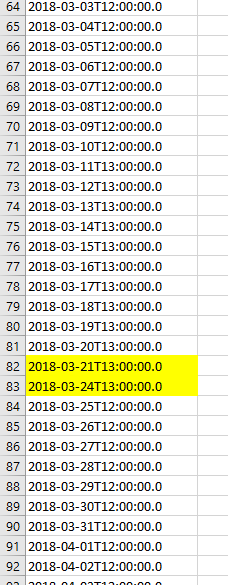

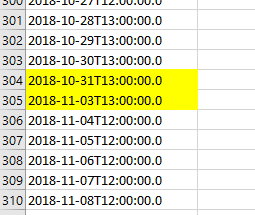

Actually there is more weirdness than just that...

* why does it go from 12:00:00 to 13:00:00 and back?

That's 4 days of issue dates that we are missing... does that mean the 359 landing probability matrix is incorrect?

    - I think so... and it should be a landing probability matrix of 363

So go back into which function?
* convert_hours_2018?
    * I think so

OR is it an artifact of the data and of forecasting during daylight savings time?

How should I check?
* check the inputs of the data... check the inputs and outputs after convert hours 2018...


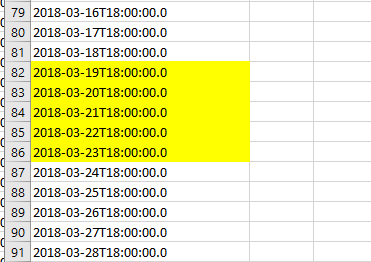

the pre_data from before convert_hours_2018 seems to have all the issues there for both march and november... so that suggests that convert_hours_2018 is the issue

In [128]:
hour_index = findall(x -> x == start_date, subset_data[!,:forecast_time])[1];
current_issue = subset_data[hour_index, :issue_time];

# find index of current issue time
issue_index = findall(x -> x == current_issue, unique_issue)[1];
# find next issue time and compare to start date
next_issue = unique_issue[issue_index + 1];
active_issues = [current_issue];
issue_indices = findall(x -> x in active_issues, subset_data[!,:issue_time]);
available_lookahead_times = subset_data[issue_indices,:forecast_time];
# filter for the times that are after the current time, (greater than the current hour)
active_times = available_lookahead_times[available_lookahead_times .>= start_date];
length_lookahead = length(active_times);

if length_lookahead == 24
    active_issues = [next_issue];
else length_lookahead > 24
    active_issues = [current_issue];
elseif length_looakeahd < 24
    println("FATAL ERROR")
end

# XXX potentially another method 
# if start_date > next_issue
#     # push!(active_issues, next_issue) # use this if 
#     active_issues = [next_issue]
# else
#     active_issues = [current_issue]
# end


1-element Vector{DateTime}:
 2018-08-28T12:00:00

In [131]:
size(subset_data)

(17232, 103)

In [ ]:
if start_date > next_issue
    # push!(active_issues, next_issue) # use this if 
    active_issues = [next_issue]
else
    active_issues = [current_issue]
end

# get the indices of the forecasts of the active issue times
issue_indices = findall(x -> x in active_issues, times[!,:issue_time])
available_lookahead_times = times[issue_indices,:forecast_time]
# filter for the times that are after the current time, (greater than the current hour)
active_times = available_lookahead_times[available_lookahead_times .>= start_date]